**리더보드**<p>
* 평가 산식 : RMSE

<br>

**데이터 설명**

1. FIFA_train.csv / FIFA_test.csv<p>
 id : 선수 고유의 아이디<P>
 name : 이름<P>
 age : 나이<P>
 continent : 선수들의 국적이 포함되어 있는 대륙입니다<P>
 contract_until : 선수의 계약기간이 언제까지인지 나타내어 줍니다<P>
 position : 선수가 선호하는 포지션입니다. ex) 공격수, 수비수 등<P>
 prefer_foot : 선수가 선호하는 발입니다. ex) 오른발<P>
 reputation : 선수가 유명한 정도입니다. ex) 높은 수치일 수록 유명한 선수<P>
 stat_overall : 선수의 현재 능력치 입니다.<P>
 stat_potential : 선수가 경험 및 노력을 통해 발전할 수 있는 정도입니다.<P>
 stat_skill_moves : 선수의 개인기 능력치 입니다.<P>
 value : FIFA가 선정한 선수의 이적 시장 가격 (단위 : 유로) 입니다.<P>

<br>

2. submission.csv (제출 파일 형식)<p>
  id : 선수 고유의 아이디<p>
  value : 예측된 선수 이적 시장 가격을 기입 <p>

  <br>
  <br>

In [ ]:
# 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
/content/drive/MyDrive/groom/semi-3/fifa_pay_prediction/03_work_code/ukseongchoi


In [ ]:
# seonghcoi
%cd '/content/drive/MyDrive/groom/semi-3/fifa_pay_prediction/03_work_code/ukseongchoi'

In [ ]:
%cd '/content/drive/MyDrive/My Colab Notebooks/교육과정/[구름] ICT 이노베이션 인공지능과정/[구름] 인공지능 장기과정/11_Semi-project 3/fifa-pay-prediction_upload/'

 # 1. 패키지 불러오기

In [ ]:
!pip install pycaret
!pip install jinja2
!pip install lightgbm
!pip install xgboost
# 설치 완료후 런타임 재시작해주세요

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import models, layers, utils, losses

# ML
from pycaret import regression

# 시각화(visualization) 도구
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as plb
import seaborn as sns

# 경고 제어
import warnings
warnings.filterwarnings(action='ignore') # 경고창 끄기

In [ ]:
# matplotlib에 한글 폰트 적용 시키는 작업

# 브라우저에서 바로 그려지도록하는 명령어 적용
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

# 2. 데이터 불러오기

In [ ]:
train = pd.read_csv("00_original_data/FIFA_train.csv")
test = pd.read_csv("00_original_data/FIFA_test.csv")
submission = pd.read_csv("00_original_data/submission.csv")

In [ ]:
# tarin 데이터
train.head(5)

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [ ]:
# test 데이터
test.head(5)

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
0,1,Cristiano Ronaldo,33,europe,2022,ST,right,5.0,94,94,5.0
1,2,Neymar Jr,26,south america,2022,ST,right,5.0,92,93,5.0
2,4,K. De Bruyne,27,europe,2023,MF,right,4.0,91,92,4.0
3,5,E. Hazard,27,europe,2020,ST,right,4.0,91,91,4.0
4,6,L. Modrić,32,europe,2020,MF,right,4.0,91,91,4.0


In [ ]:
# submission 데이터
submission.head(5)

,id,value
0,1,0
1,2,0
2,4,0
3,5,0
4,6,0


# 3. 데이터 분석

Train 연속형(숫자형) 데이터 열의 상관 계산 분석
상관관계 분석을 통해서 선수 가치에 많은 영향을 줄 수 있는 데이터를 찾을 수 있음.
상대적으로 선수의 명성도와 현재 능력치와 앞으로의 발전 정도가 상관관계가 높은 평이었으나, 이것만 보기에는 애매한 감이 있음.
의외로 나이에 대한 가치 기대값이 낮은 것을 알 수 있음
축구구단도 이윤을 추구해야하는 축구사업이기 때문에 이름값과 그에 맞는 현재 폼이 선수 가치에 많은 영향을 주지 않았나 생각이 듬.

In [ ]:
# 결측치 등을 파악하기 위한, 데이터의 정보 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


In [ ]:
# 데이터의 통계값을 추출하여 데이터의 성질 파악하기

# 수치형 데이터의 통계값 추출
train.describe()

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
count,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8.932000e+03
mean,7966.775750,25.209136,1.130878,67.091133,71.997201,2.401702,2.778673e+06
std,4844.428521,4.635515,0.423792,6.854910,5.988147,0.776048,5.840982e+06
min,0.000000,16.000000,1.000000,47.000000,48.000000,1.000000,1.000000e+04
25%,3751.750000,21.000000,1.000000,63.000000,68.000000,2.000000,3.750000e+05
50%,7696.500000,25.000000,1.000000,67.000000,72.000000,2.000000,8.250000e+05
75%,12082.250000,28.000000,1.000000,72.000000,76.000000,3.000000,2.600000e+06
max,16948.000000,40.000000,5.000000,94.000000,94.000000,5.000000,1.105000e+08


In [ ]:
# 범주형 데이터의 통계값 추출
train.describe(include='O')

,name,continent,contract_until,position,prefer_foot
count,8932,8932,8932,8932,8932
unique,8932,5,17,4,2
top,L. Messi,europe,2019,MF,right
freq,1,5322,2366,3428,6837


### 시각화를 통하여 데이터의 상관관계 알아보기

* 이적료 예측이 우리가 해결하고자 하는 문제이므로, 이적료를 기준으로 전체 데이터에 대한 추세를 확인해본다.

* **데이터의 분포를 확인하는 시각화**
<p>
    : 데이터의 분포는 다음과 같이 살필 수 있으며, 대표적인 몇 가지만 살펴본다.

    * 범주형 : barplot
    * 수치형
      * 이산형 : barplot
      * 연속형 : kdeplot, histogram
    * 범주형 + 수치형 : boxplot, violinplot, etc, barplot
    * 수치형 + 수치형 : scatter

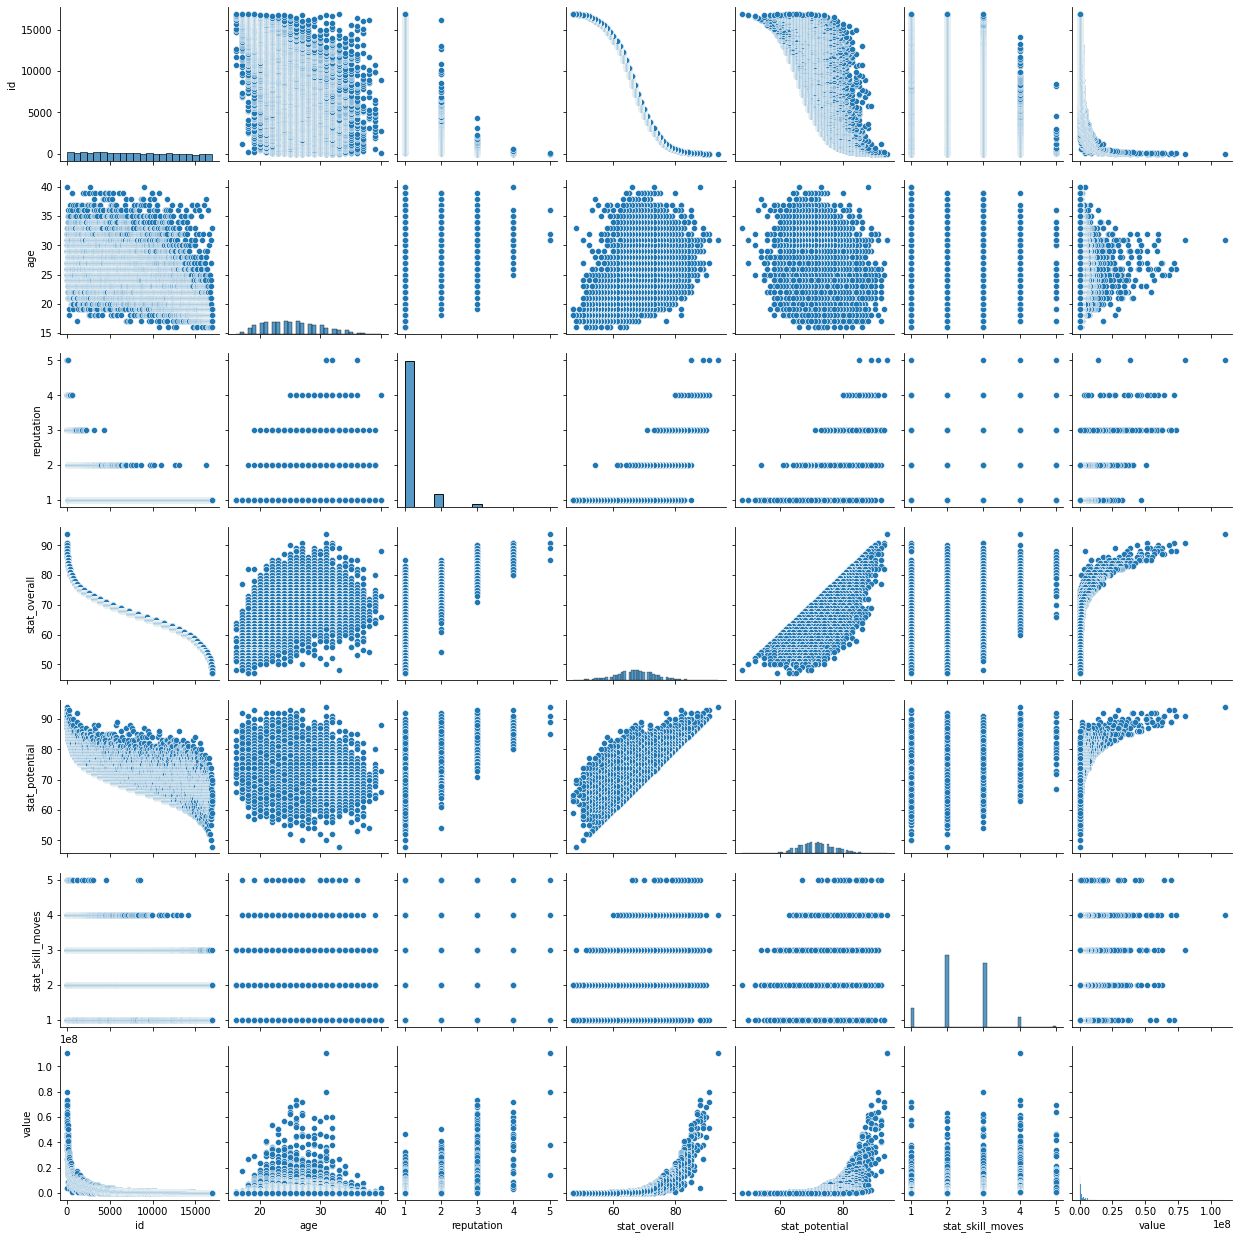

In [ ]:
# 독립변수와 종속변수의 관계를 스캐터플롯(scatter plot)으로 살펴보기
sns.pairplot(train)
plt.show()

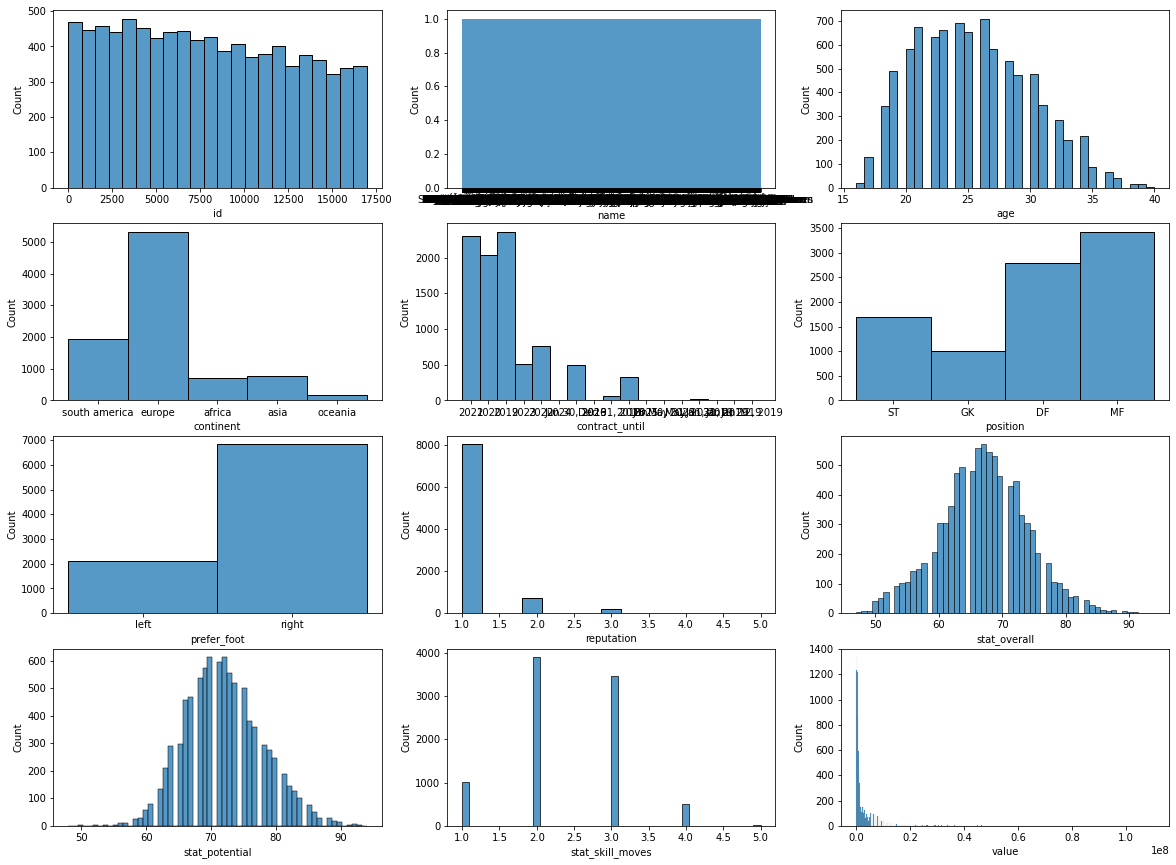

In [ ]:
# 데이터를 골라서 자세히 확인해보기

f, axes = plt.subplots(4,3 , figsize=(20,15))
axes = axes.flatten()
for col, ax in zip(train.columns, axes):
    sns.histplot(data=train, x=col, ax=ax)
plt.show()

In [ ]:
# corr = NA/null 값을 제외한 열의 쌍별 상관 계산
train.corr().style.background_gradient(cmap='Blues_r')

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
id,1.000000,-0.475785,-0.423739,-0.972374,-0.630199,-0.402455,-0.544280
age,-0.475785,1.000000,0.263468,0.467345,-0.231303,0.039362,0.087319
reputation,-0.423739,0.263468,1.000000,0.521389,0.399183,0.196582,0.665982
stat_overall,-0.972374,0.467345,0.521389,1.000000,0.665453,0.400164,0.658444
stat_potential,-0.630199,-0.231303,0.399183,0.665453,1.000000,0.332578,0.611907
stat_skill_moves,-0.402455,0.039362,0.196582,0.400164,0.332578,1.000000,0.298500
value,-0.544280,0.087319,0.665982,0.658444,0.611907,0.298500,1.000000


* train 데이터를 분석해 봤을 때 현재폼과 포텐셜이 가장 높은 상관 관계를 보인다.



#### 이적 시장 가격

[Text(0.5, 1.0, '이적료_로그스케일 박스플롯')]

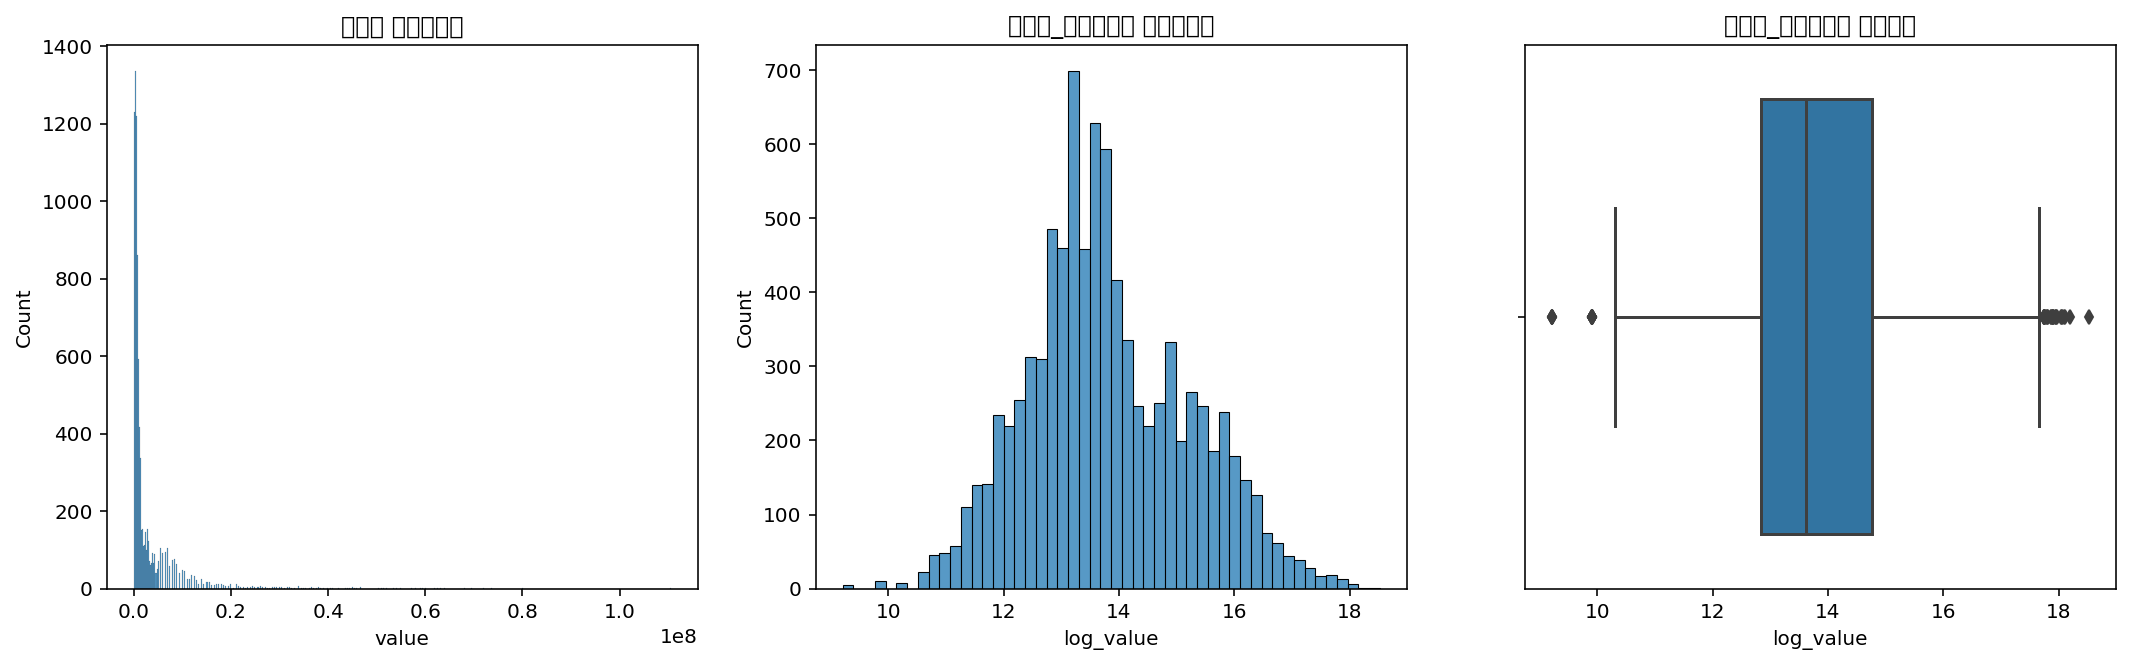

In [ ]:
# 도화지 그리기
fig, axes = plt.subplots(1,3)
fig.set_size_inches(18,5)

# 이적료에 log 적용
train["log_value"] = np.log(train["value"])

sns.histplot(x="value", data=train, ax=axes[0])
axes[0].set(title = "이적료 히스토그램")
sns.histplot(x="log_value", data=train, ax=axes[1])
axes[1].set(title = "이적료_로그스케일 히스토그램")
sns.boxplot(x="log_value", data=train, ax=axes[2])
axes[2].set(title = "이적료_로그스케일 박스플롯")

* 이적 시장 가격의 편차가 매우 크기 때문에 log scale을 적용시킴
* 분석을 진행할때 log scale의 value도 target으로 시도해보면 좋을 것 같음
* log scale 후에도 이상치 발견, log scale 기준 10~18까지 데이터만 사용하면 좋을 것 같음

#### 나이별 이적료

[Text(0, 0.5, '이적료'), Text(0.5, 0, '나이'), Text(0.5, 1.0, '나이별 평균 이적료')]

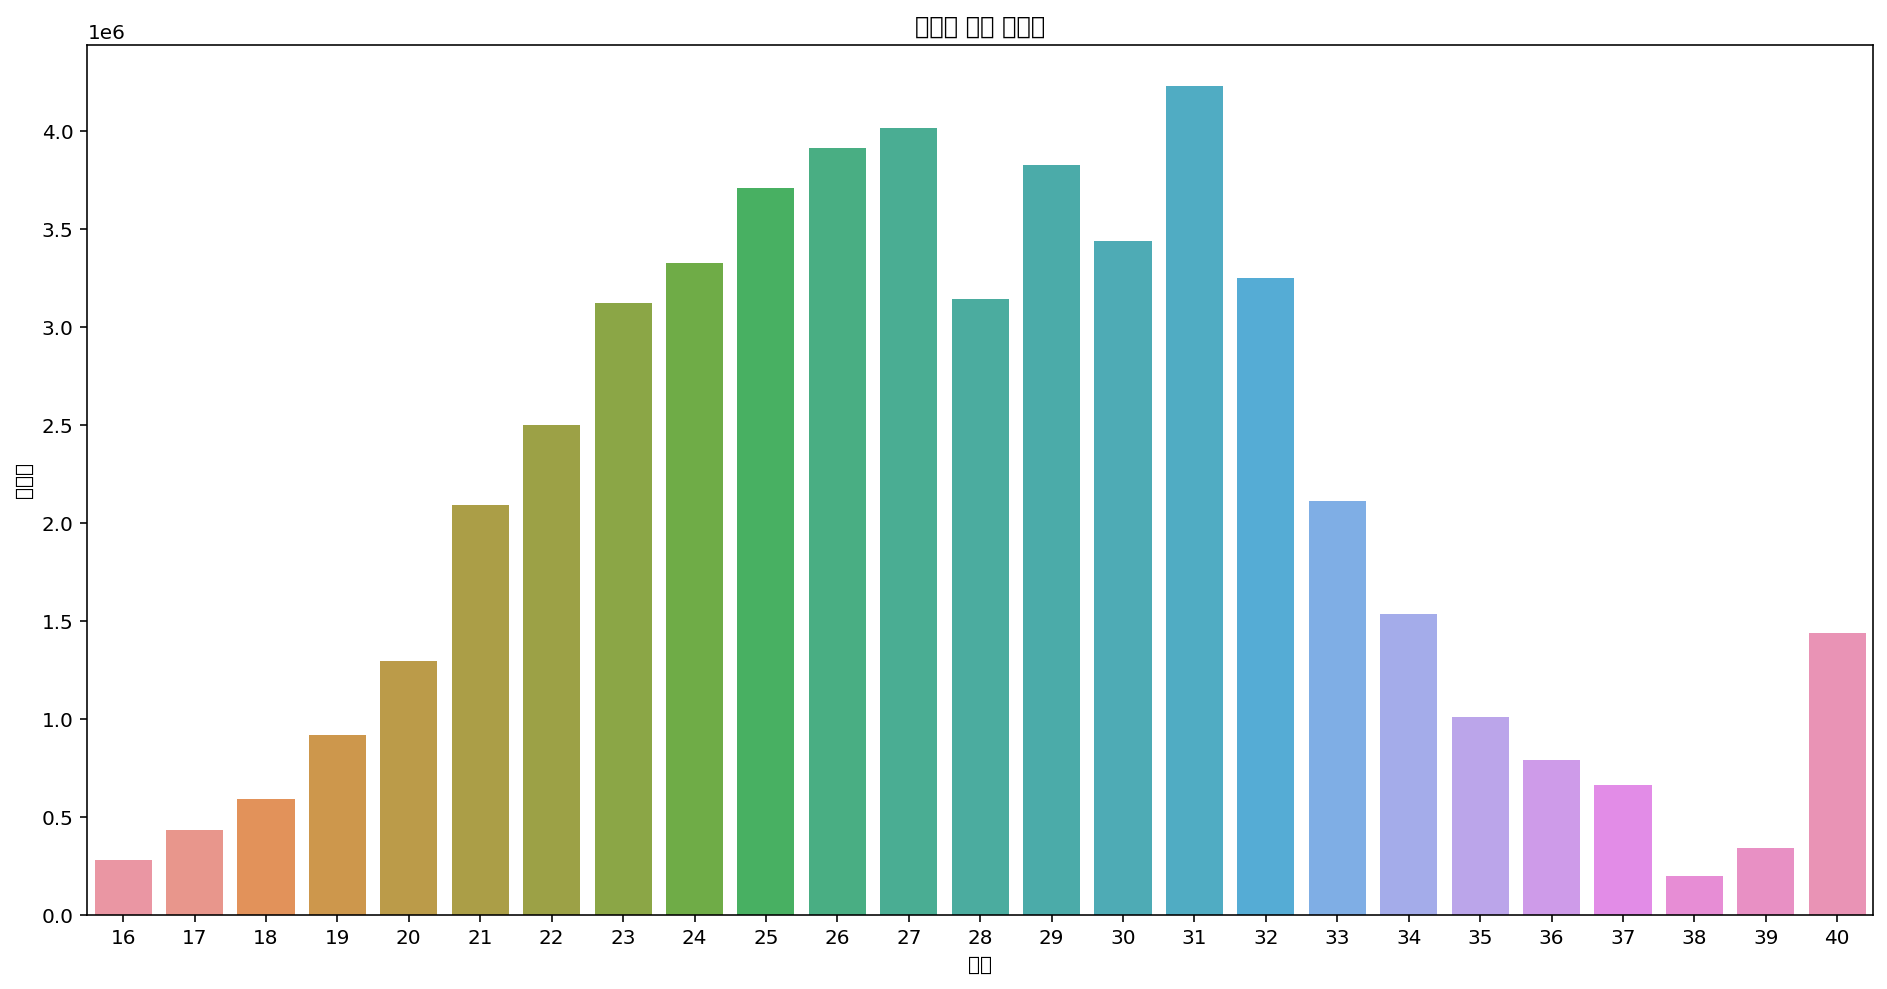

In [ ]:
# 도화지 그리기
fig, axe = plt.subplots()
fig.set_size_inches(16,8)


# 나이별 이적료
group_age_value = train.groupby("age")["value"].mean()
group_age_value = group_age_value.reset_index() # 순서가 섞인 인덱스를 다시 처음부터 재배열 해서 저장

# 나이별 이적료 막대 그래프
sns.barplot(x="age", y="value", data=group_age_value)

# 설정
axe.set(title = "나이별 이적료",
      xlabel="나이",
      ylabel="이적료")

#### 계약 기간별 이적료

In [ ]:
# 시각화를 위한 임시 전처리

# train 원본 데이터를 변형하지 않게 하기위해 복사함
temporary_train = train.copy()

# 계약 연도에 월, 일 값이 붙어 있는 데이터를 전처리한 뒤,
# 계약 연도를 object -> int 로 변환
def func(string:object) -> int:
    string = string[-4:] # 계약연도가 제일 끝에 있거나 단독으로 쓰이고 있어 뒤에서 4번째부터 가지고 옴
    return int(string)

temporary_train['contract_until'] = temporary_train['contract_until'].apply(func)

[Text(0, 0.5, '이적료'), Text(0.5, 0, '계약 기간'), Text(0.5, 1.0, '계약 기간별 평균 이적료')]

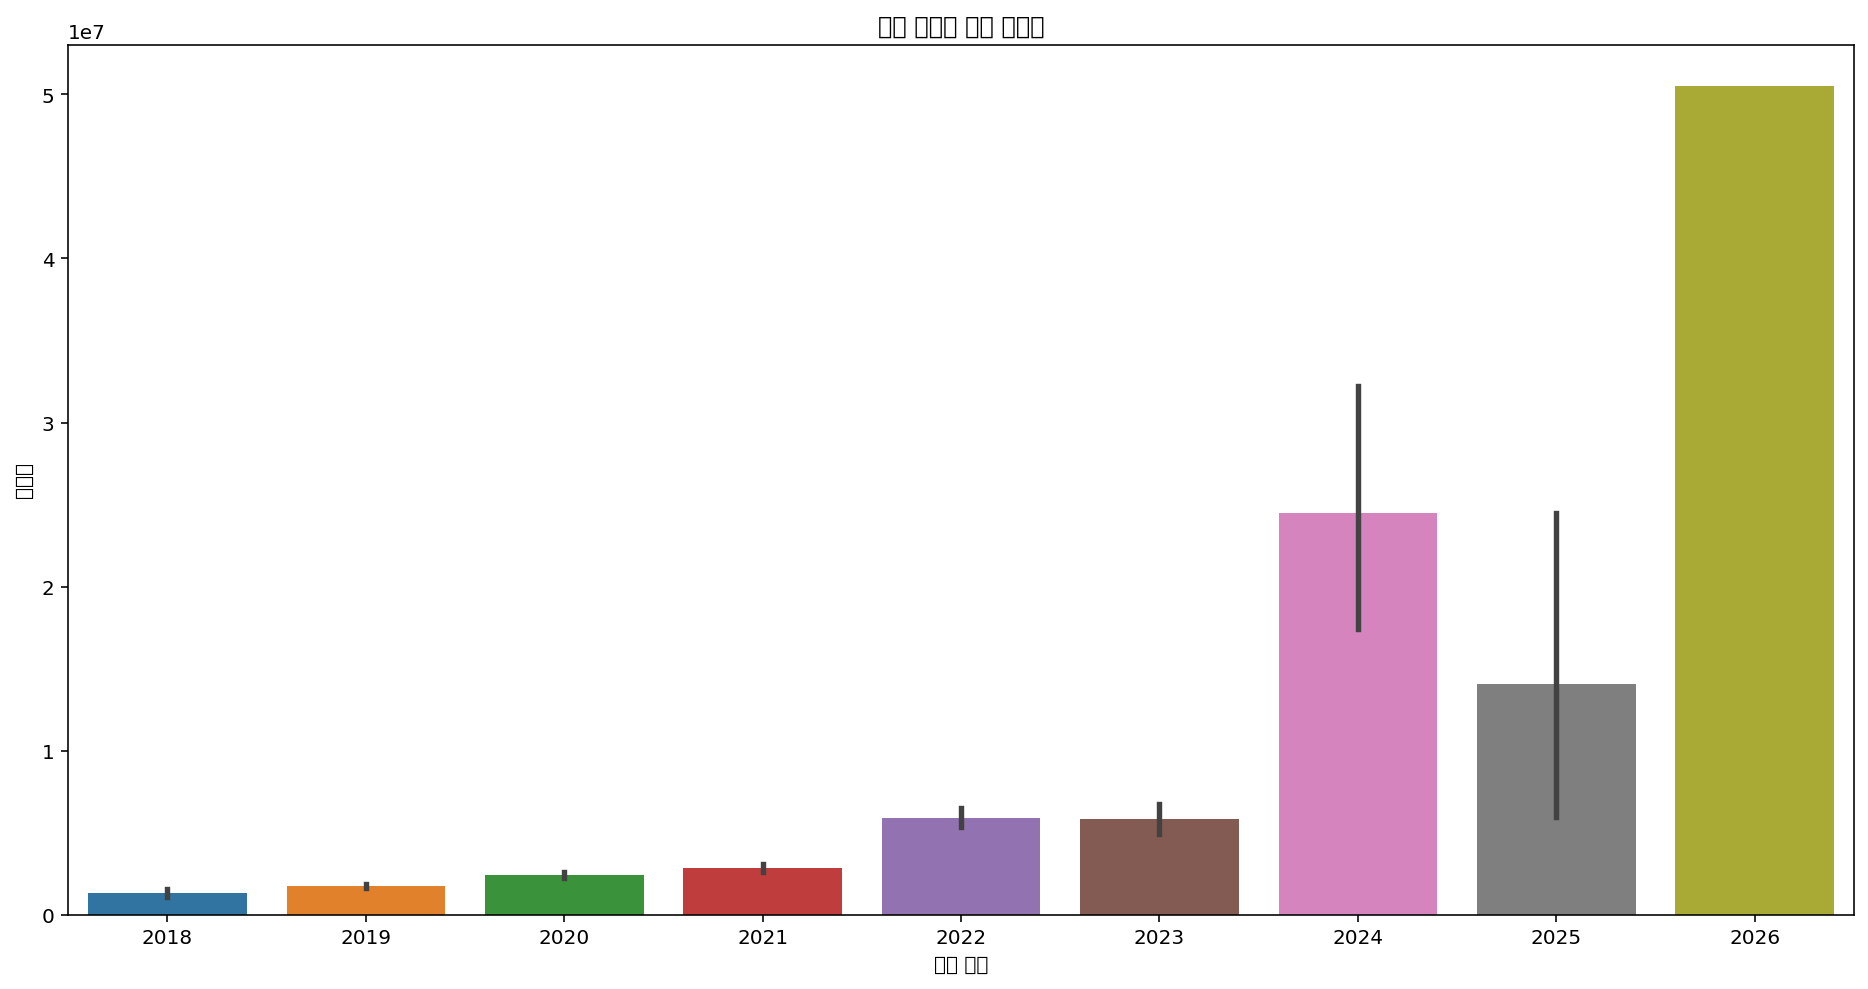

In [ ]:
# 도화지 그리기
fig, axe = plt.subplots()
fig.set_size_inches(16,8)

# 계약 기간별 이적료 막대 그래프
sns.barplot(x="contract_until", y="value", data=temporary_train)

# 설정
axe.set(title = "계약 기간별 이적료",
      xlabel="계약 기간",
      ylabel="이적료")

#### 유명도별 이적료

[Text(0, 0.5, '이적료'), Text(0.5, 0, '유명도'), Text(0.5, 1.0, '유명도별 평균 이적료')]

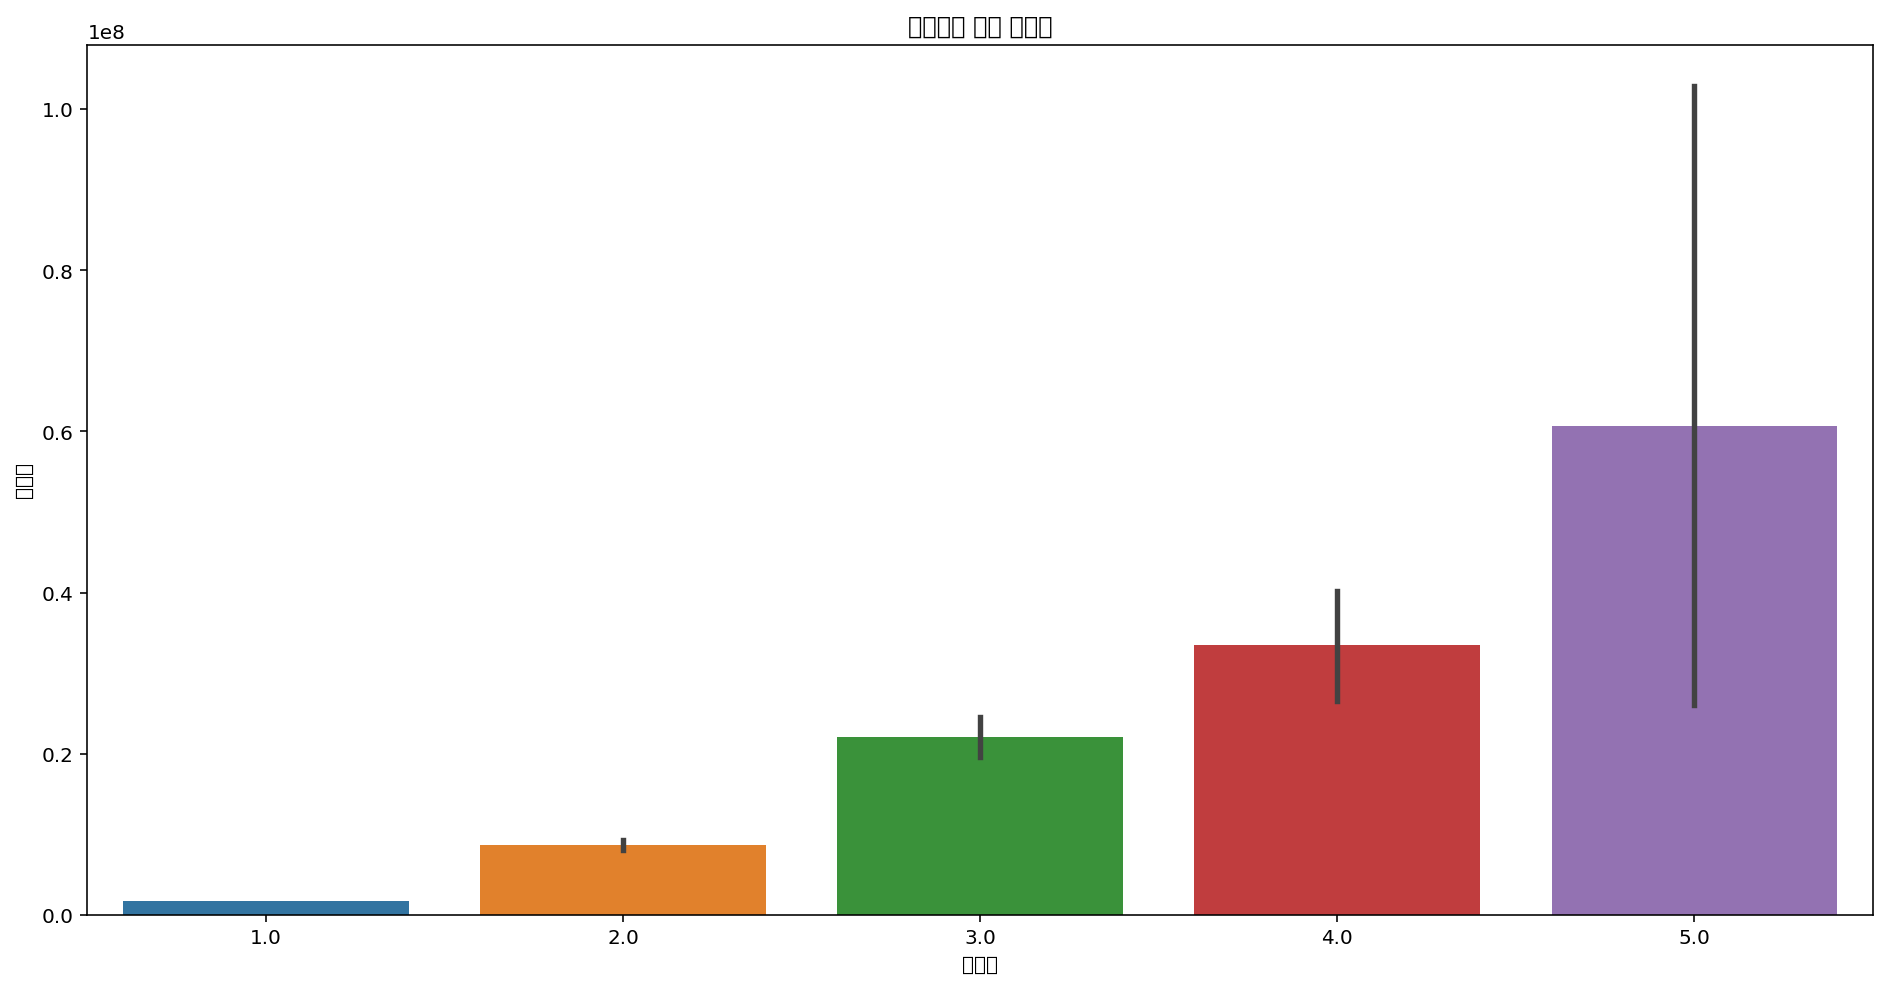

In [ ]:
# 도화지 그리기
fig, axe = plt.subplots()
fig.set_size_inches(16,8)

# 유명도별 이적료 막대 그래프
sns.barplot(x="reputation", y="value", data=train)

# 설정
axe.set(title = "유명도별 이적료",
      xlabel="유명도",
      ylabel="이적료")

#### 현재 능력치별 이적료

[Text(0, 0.5, '이적료'), Text(0.5, 0, '현재 능력치'), Text(0.5, 1.0, '현재 능력치별 평균 이적료')]

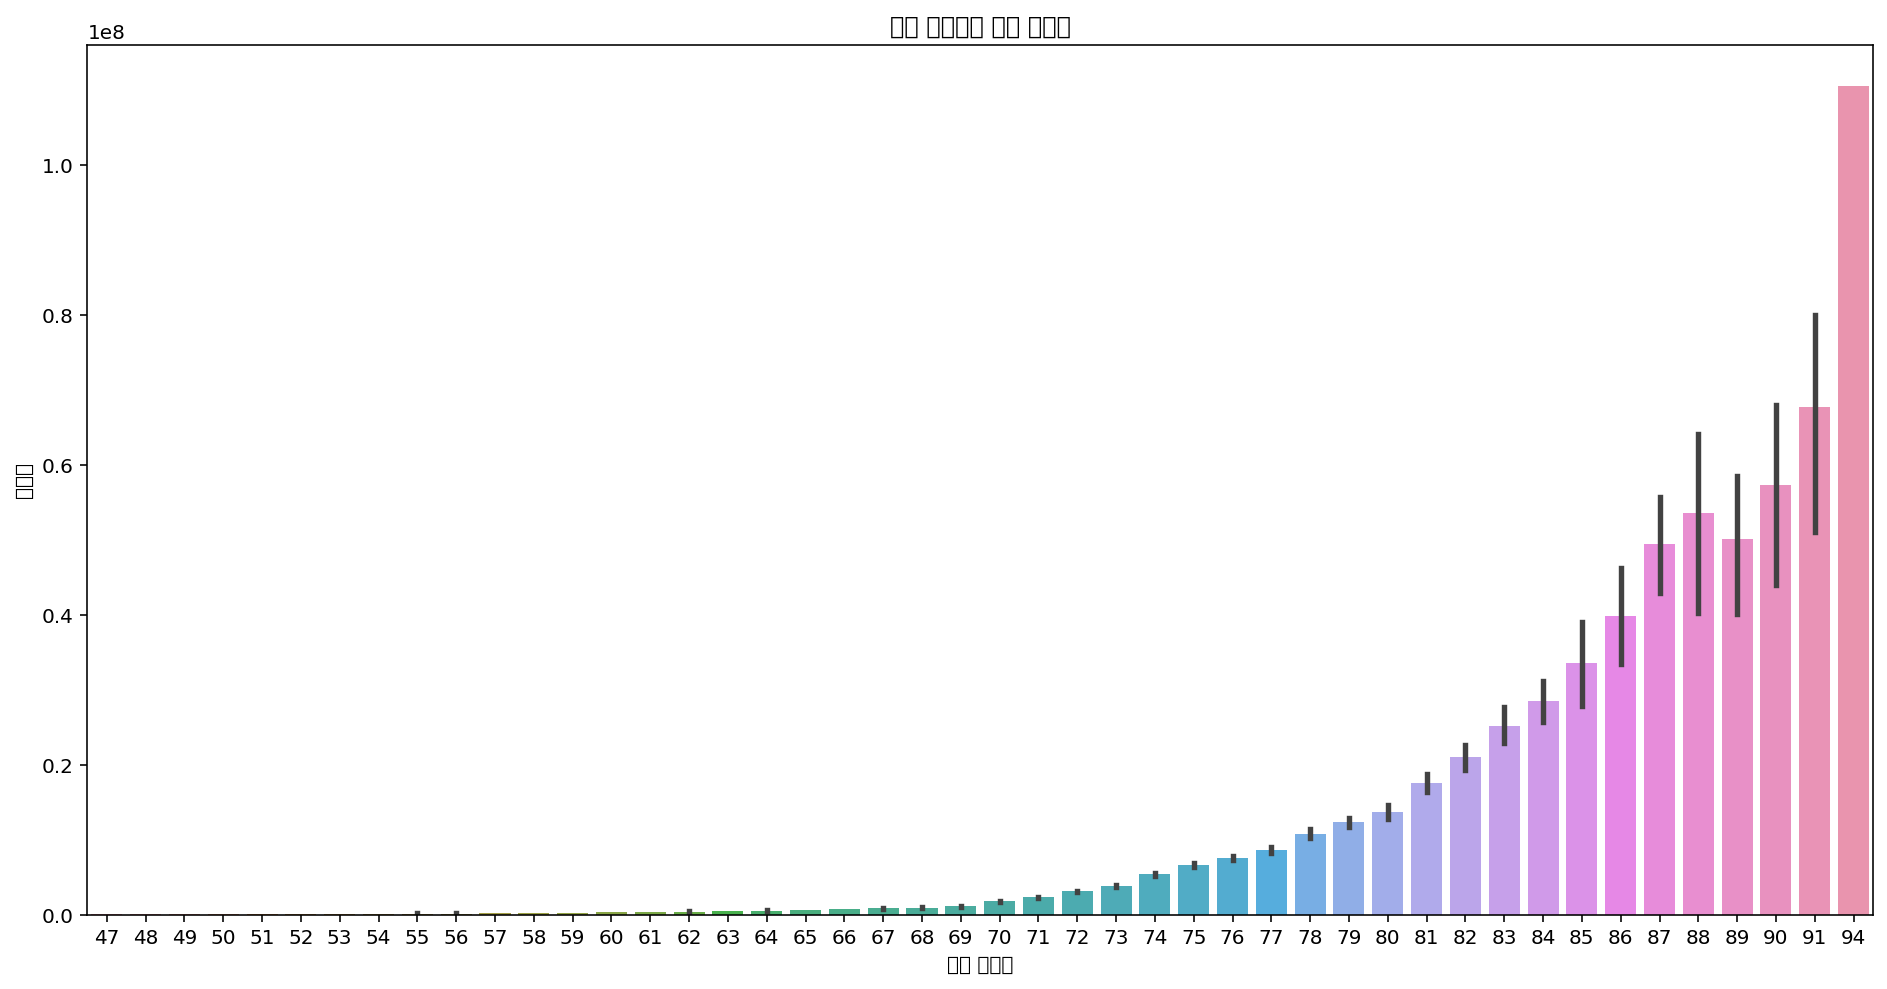

In [ ]:
# 도화지 그리기
fig, axe = plt.subplots()
fig.set_size_inches(16,8)

# 현재 능력치별 이적료 막대 그래프
sns.barplot(x="stat_overall", y="value", data=train)

# 설정
axe.set(title = "현재 능력치별 이적료",
      xlabel="현재 능력치",
      ylabel="이적료")

#### 발전 가능성별 이적료

[Text(0, 0.5, '이적료'), Text(0.5, 0, '발전 가능성'), Text(0.5, 1.0, '발전 가능성별 평균 이적료')]

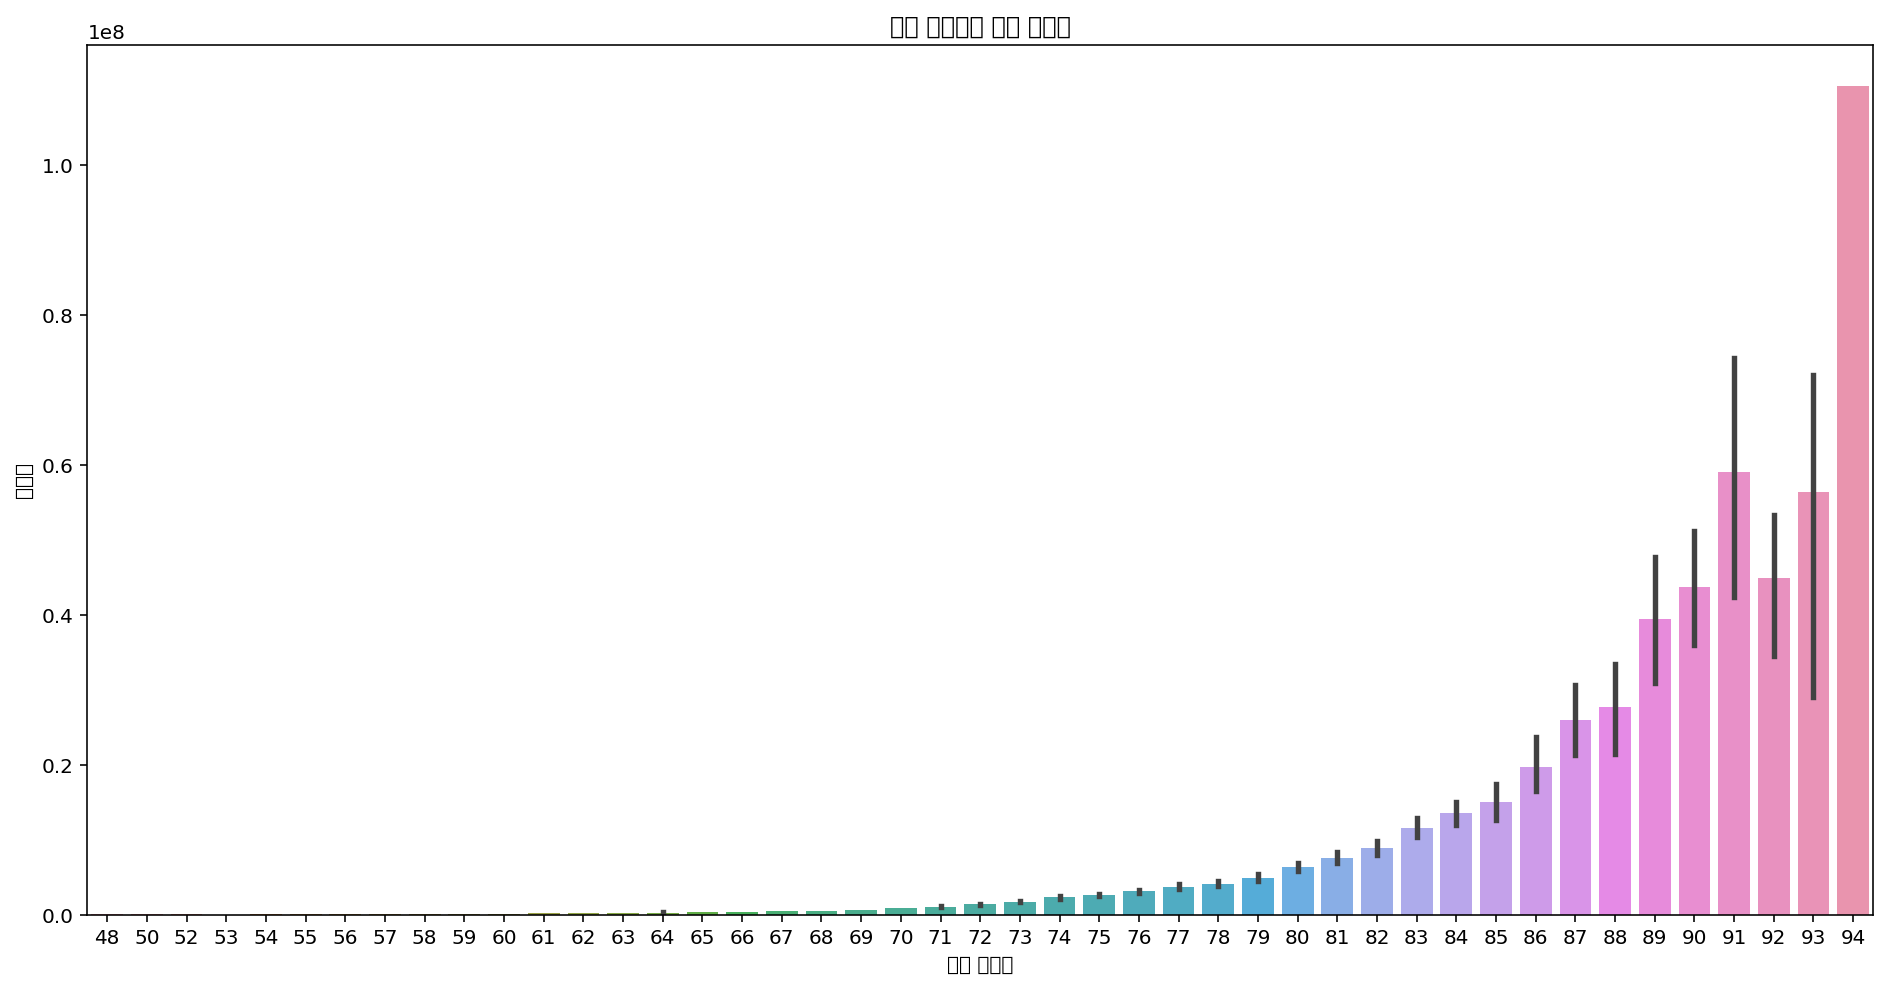

In [ ]:
# 도화지 그리기
fig, axe = plt.subplots()
fig.set_size_inches(16,8)

# 발전 가능성별 이적료 막대 그래프
sns.barplot(x="stat_potential", y="value", data=train)

# 설정
axe.set(title = "발전 가능성별 이적료",
      xlabel="발전 가능성",
      ylabel="이적료")

#### 개인 능력치별 이적료

[Text(0, 0.5, '이적료'), Text(0.5, 0, '개인 능력치'), Text(0.5, 1.0, '개인 능력치별 평균 이적료')]

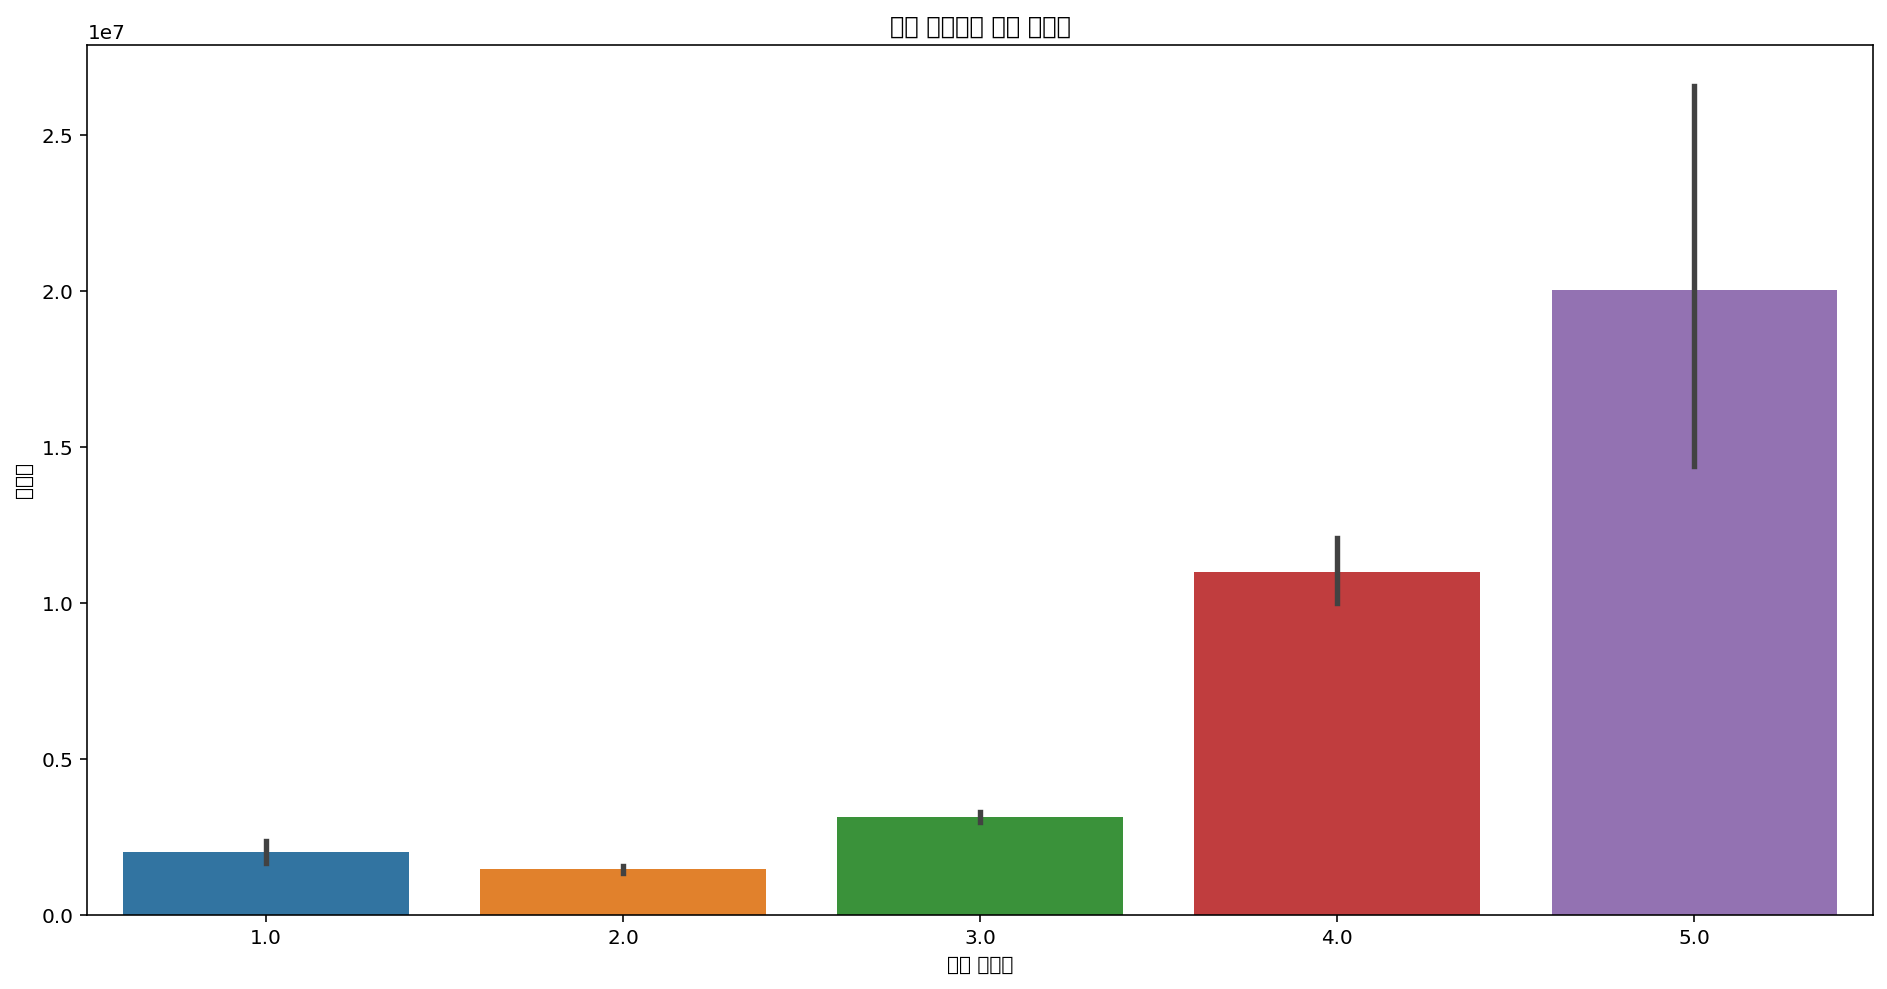

In [ ]:
# 도화지 그리기
fig, axe = plt.subplots()
fig.set_size_inches(16,8)

# 개인 능력치별 이적료 막대 그래프
sns.barplot(x="stat_skill_moves", y="value", data=train)

# 설정
axe.set(title = "개인 능력치별 이적료",
      xlabel="개인 능력치",
      ylabel="이적료")

#### 국적별 이적료

[Text(0, 0.5, '이적료'), Text(0.5, 0, '국적'), Text(0.5, 1.0, '국적별 평균 이적료')]

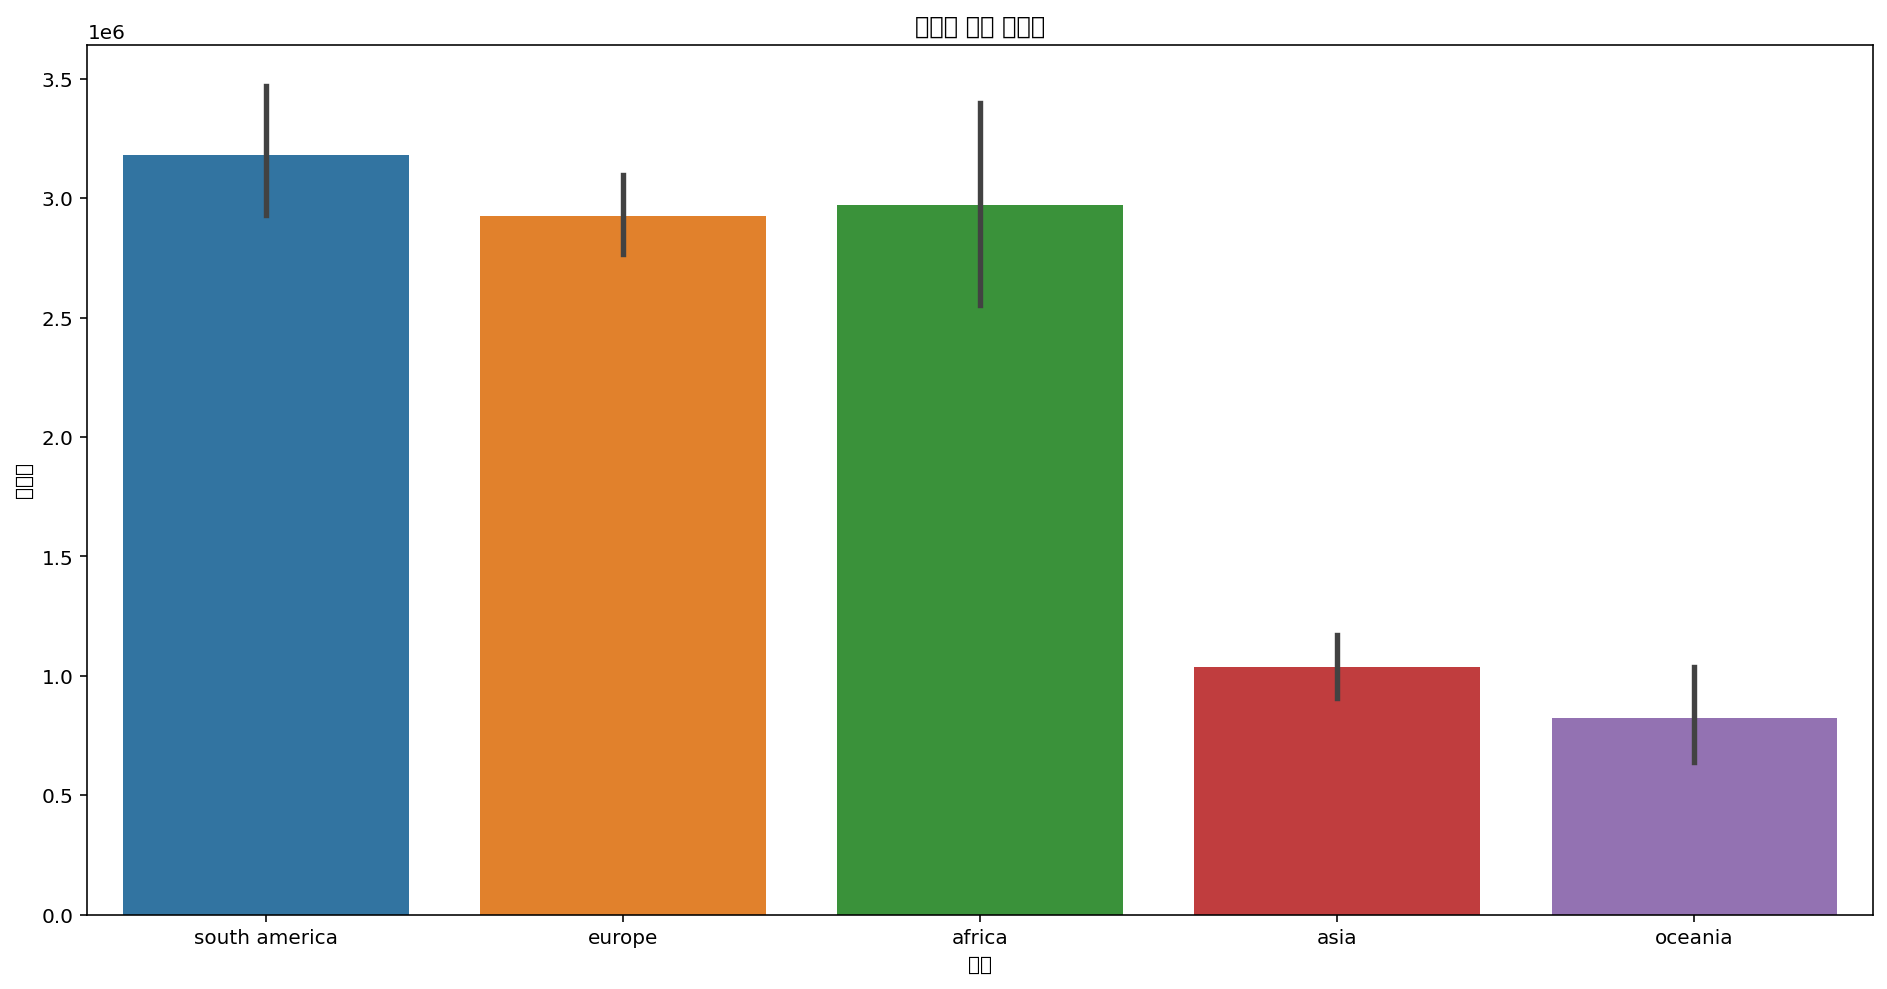

In [ ]:
# 도화지 그리기
fig, axe = plt.subplots()
fig.set_size_inches(16,8)

# 국적별 이적료 막대 그래프
sns.barplot(x="continent", y="value", data=train)

# 설정
axe.set(title = "국적별 이적료",
      xlabel="국적",
      ylabel="이적료")

#### 포지션별 이적료

[Text(0, 0.5, '이적료'), Text(0.5, 0, '포지션'), Text(0.5, 1.0, '포지션별 평균 이적료')]

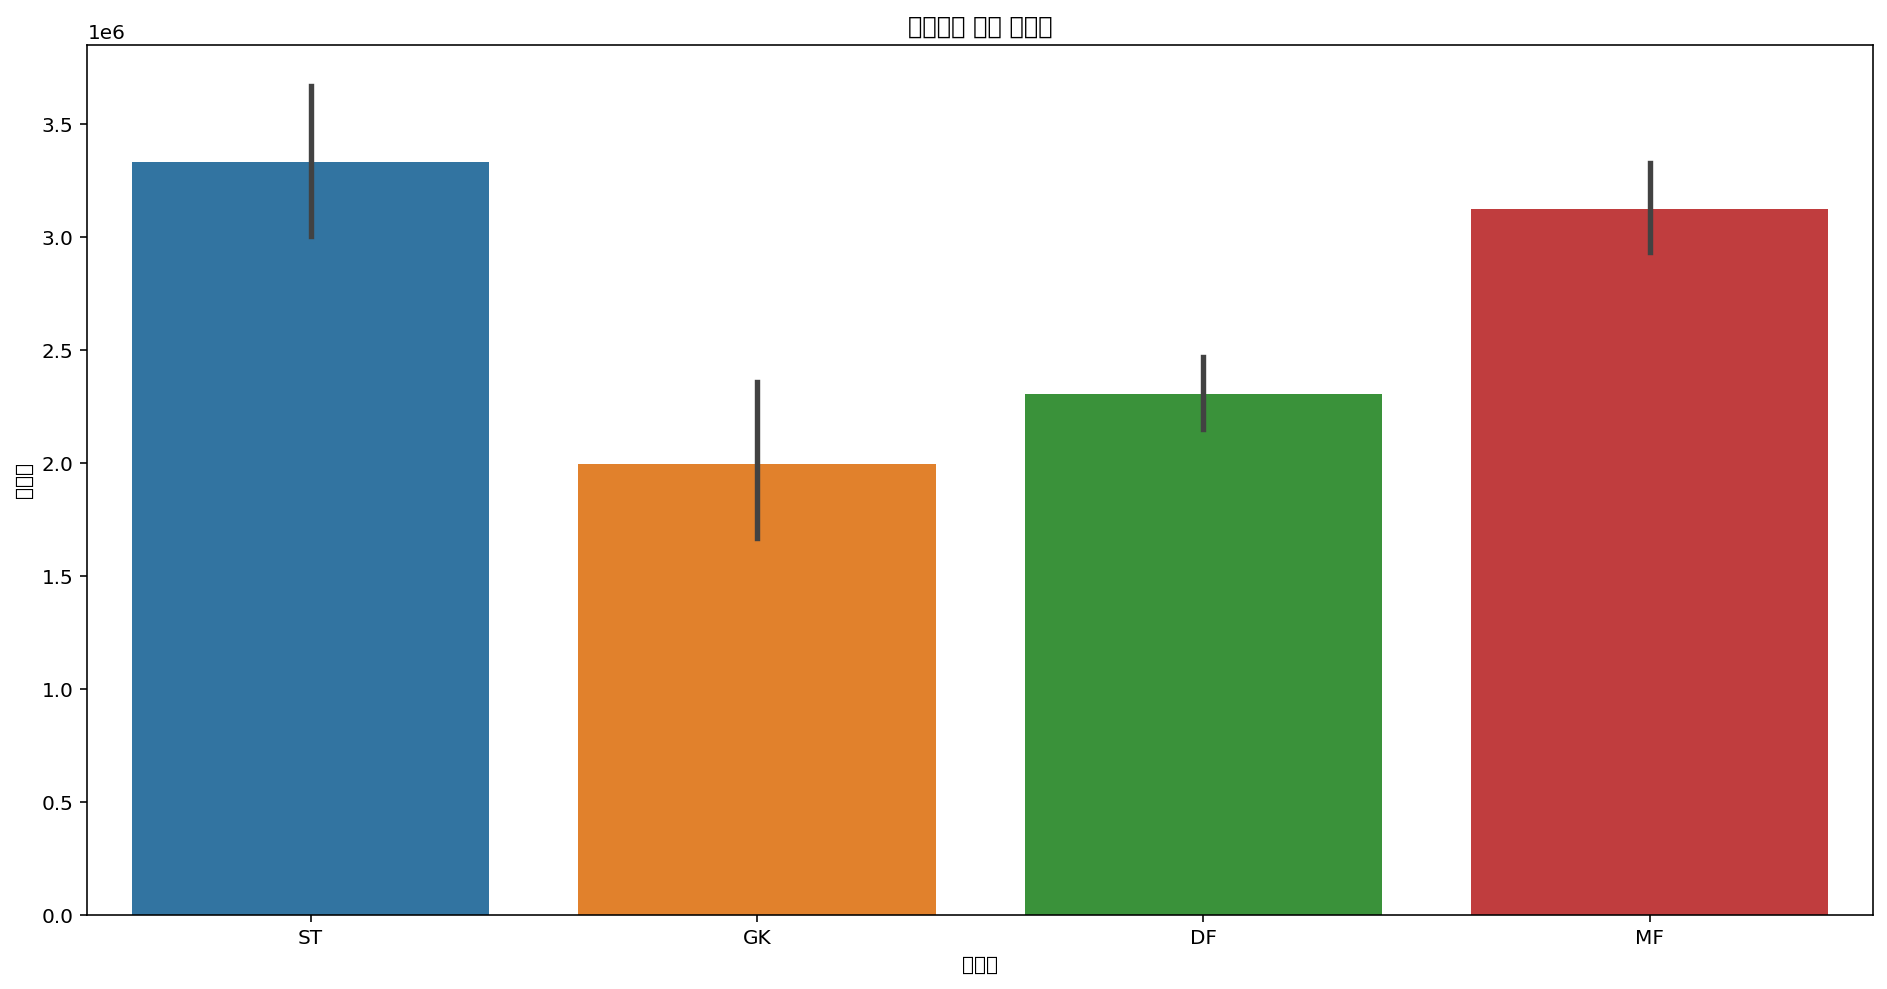

In [ ]:
# 도화지 그리기
fig, axe = plt.subplots()
fig.set_size_inches(16,8)

# 포지션별 이적료 막대 그래프
sns.barplot(x="position", y="value", data=train)

# 설정
axe.set(title = "포지션별 이적료",
      xlabel="포지션",
      ylabel="이적료")

#### 선호하는 발별 이적료

[Text(0, 0.5, '이적료'), Text(0.5, 0, '선호하는 발'), Text(0.5, 1.0, '선호하는 발별 평균 이적료')]

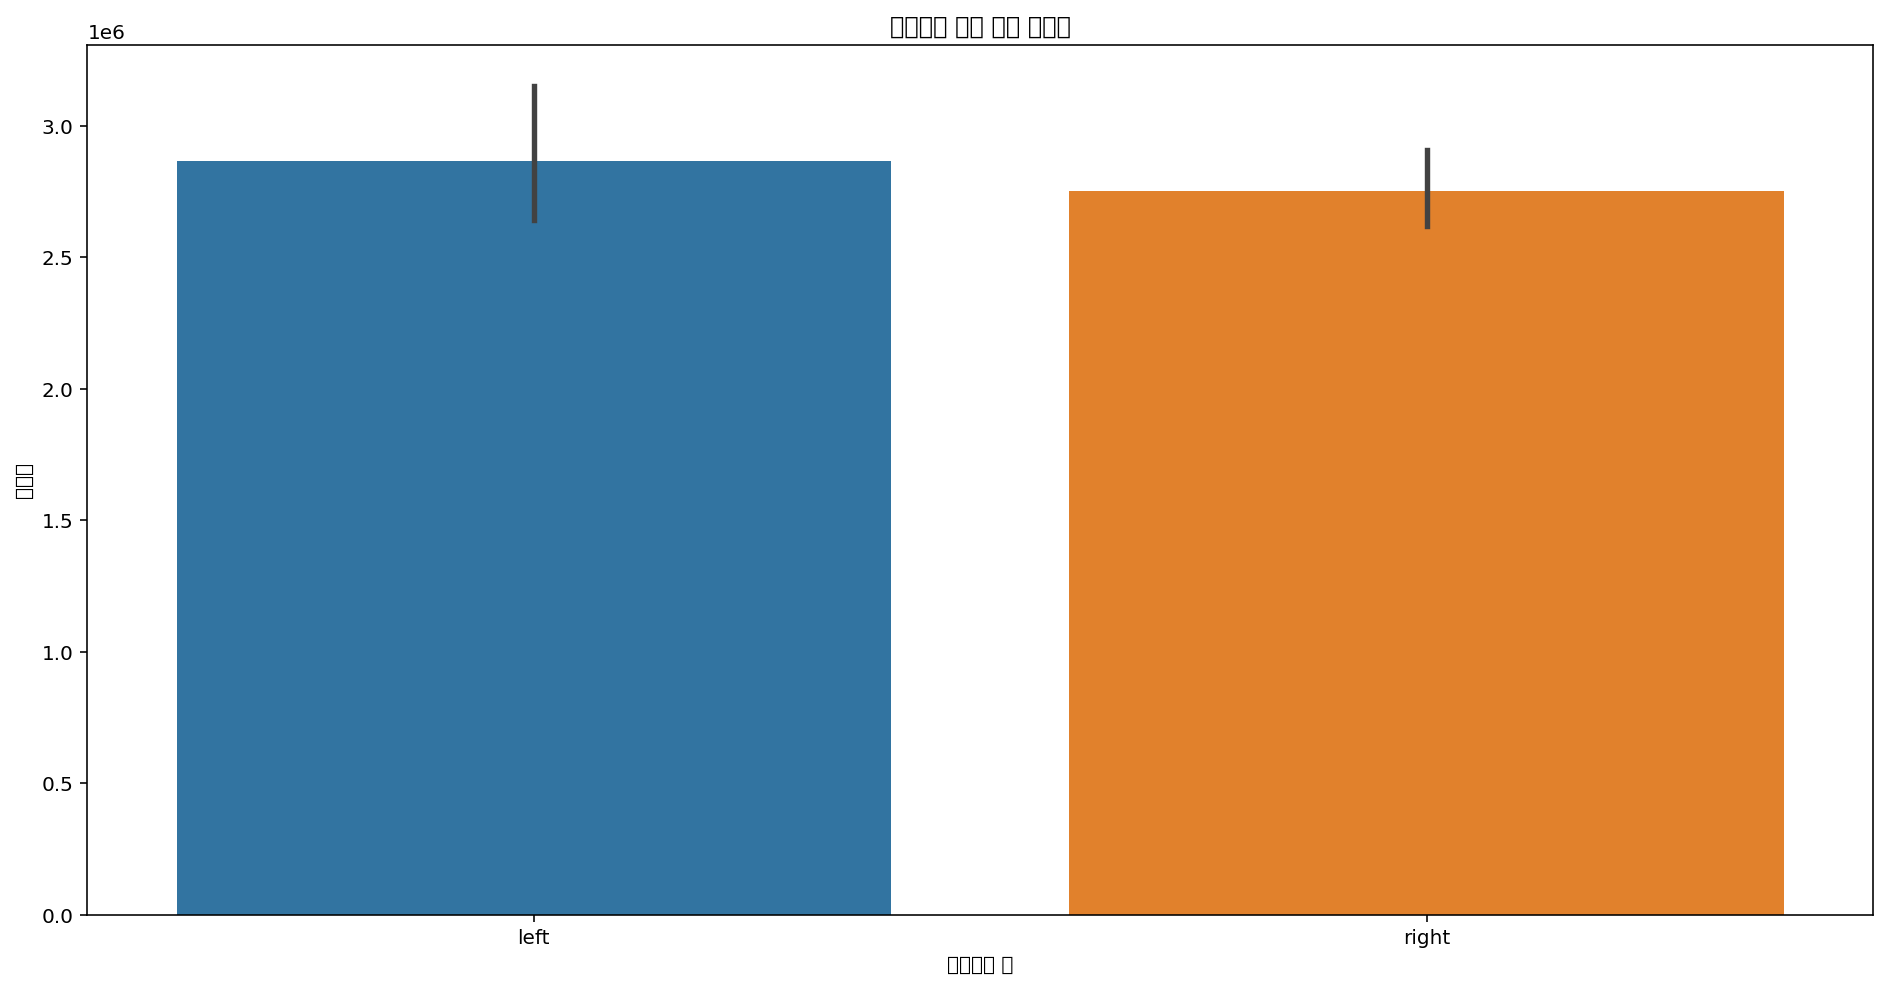

In [ ]:
# 도화지 그리기
fig, axe = plt.subplots()
fig.set_size_inches(16,8)

# 선호하는 발별 이적료 막대 그래프
sns.barplot(x="prefer_foot", y="value", data=train)

# 설정
axe.set(title = "선호하는 발별 이적료",
      xlabel="선호하는 발",
      ylabel="이적료")

# 4. 데이터 전처리

In [ ]:
# 필요하지 않는 feature 값 제거
train.drop(['id', 'name'], axis = 1, inplace = True)
test.drop(['id', 'name'], axis = 1, inplace = True)

In [ ]:
#타겟 데이터
y_train = train['value']

#학습 데이터
x_train = train.copy()

#타겟 생성 후 필요없는 열제거
del x_train['value']

In [ ]:
# 카테고리 값 확인
print(x_train['continent'].unique())
print(x_train['position'].unique())
print(x_train['prefer_foot'].unique())

['south america' 'europe' 'africa' 'asia' 'oceania']
['ST' 'GK' 'DF' 'MF']
['left' 'right']


In [ ]:
# categorical data를 담고있는 Series는 특수 메서드인 cat 속성이 있다.
# 이를 통해 catagories 와 codes 나 categorical 메서드 등에 쉽게 접근할 수 있다.
# 하지만 시리즈에 바로 categories나 codes를 사용하면 에러가 발생하는데 이때 이용하는 것이 cat 속성이다.

x_train['continent']=x_train['continent'].astype('category').cat.codes
test['continent'] = test['continent'].astype('category').cat.codes

x_train['position'] = x_train['position'].astype('category').cat.codes
test['position'] = test['position'].astype('category').cat.codes

x_train['prefer_foot'] = x_train['prefer_foot'].astype('category').cat.codes
test['prefer_foot'] = test['prefer_foot'].astype('category').cat.codes

In [ ]:
# 계약 연도에 월, 일 값이 붙어 있는 데이터를 전처리한 뒤,
# 계약 연도에서 object -> int 로 변환
def func(string:object) -> int:
    string = string[-4:] # 계약연도가 제일 끝에 있거나 단독으로 쓰이고 있어 뒤에서 4번째부터 가지고 옴.
    return int(string)

x_train['contract_until'] = x_train['contract_until'].apply(func)
test['contract_until'] = test['contract_until'].apply(func)

In [ ]:
print(y_train)
x_train
# test

0       110500000.0
1        72000000.0
2        80000000.0
3        51000000.0
4        68000000.0
           ...     
8927        60000.0
8928        40000.0
8929        50000.0
8930        50000.0
8931        60000.0
Name: value, Length: 8932, dtype: float64


,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
0,31,4,2021,3,0,5.0,94,94,4.0
1,27,2,2020,1,1,4.0,91,93,1.0
2,31,4,2021,3,1,5.0,91,91,3.0
3,32,2,2020,0,1,4.0,91,91,3.0
4,25,2,2021,1,1,3.0,90,93,1.0
...,...,...,...,...,...,...,...,...,...
8927,18,0,2019,2,1,1.0,48,63,3.0
8928,19,2,2020,0,1,1.0,47,59,2.0
8929,18,4,2021,0,1,1.0,47,64,2.0
8930,18,2,2021,1,1,1.0,47,65,1.0


* 어떤 데이터로 볼 것인지, 확실한 부분
  * continent : 카테고리컬
  * position: 카테고리컬
  * stat_overall : 뉴메리컬
  * stat_potential : 뉴메리컬

* 관련없는 데이터일 가능성이 크므로, 포함되었을 경우와 포함되지 않았을 경우의 예측값 비교해보기
  * prefer_foot : 카테고리컬

* 모두 적용해보기
  * reputation : 뉴메리컬, 카테고리컬
  * contract_until : 뉴메리컬, 카테고리컬
  * age : 뉴메리컬, 카테고리컬
  * stat_skill_moves : 뉴메리컬 카테고리컬

In [ ]:
x_train.keys()

Index(['age', 'continent', 'contract_until', 'position', 'prefer_foot',
       'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves'],
      dtype='object')

In [ ]:
# 카테고리 특성 추출

def on_hot_vector(series):
  num = np.unique(series, axis=0)
  num = num.shape[0]

  encoding = np.eye(num)[series]
  en_df = pd.DataFrame(encoding)

  make_name =[]
  for i in range(num):
    
    make_name.append(series.name + str(i))

  en_df.columns = make_name
  return en_df

In [ ]:
#concat
continent_f = on_hot_vector(x_train['continent'])
position_f = on_hot_vector(x_train['position'])
prefer_foot = on_hot_vector(x_train['prefer_foot'])

vector_df = pd.concat([position_f,continent_f,prefer_foot],axis=1)

del x_train['continent']
del x_train['position']
del x_train['prefer_foot']

x_train = pd.concat([x_train,vector_df],axis = 1)

# 5. 모델 구현 및 적용

### ML

In [ ]:
model = regression.setup(data=train, 
              target='value', 
              session_id=42) # Random seed 

,Description,Value
0,session_id,42
1,Target,value
2,Original Data,"(8932, 10)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(6252, 26)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[], target='value',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy='...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'passthrough'),
              

In [ ]:
top_5_models = regression.compare_models(sort='RMSE', n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2.425315e+05,6.560573e+11,7.671368e+05,0.9808,0.3464,0.2179,0.355
lightgbm,Light Gradient Boosting Machine,1.789131e+05,6.885005e+11,7.777669e+05,0.9806,0.1336,0.0770,0.130
knn,K Neighbors Regressor,2.426398e+05,7.020766e+11,8.020719e+05,0.9797,0.1273,0.0908,0.074
rf,Random Forest Regressor,1.912832e+05,7.710326e+11,8.405737e+05,0.9777,0.1033,0.0600,1.434
et,Extra Trees Regressor,1.923797e+05,8.333786e+11,8.740952e+05,0.9756,0.1154,0.0619,1.746
dt,Decision Tree Regressor,2.512017e+05,1.437223e+12,1.165037e+06,0.9546,0.1394,0.0694,0.031
ada,AdaBoost Regressor,1.891587e+06,4.865451e+12,2.189846e+06,0.8404,1.6205,5.4542,0.392
br,Bayesian Ridge,1.844366e+06,1.082571e+13,3.258662e+06,0.6608,1.3316,4.7069,0.020
ridge,Ridge Regression,1.845494e+06,1.082547e+13,3.258805e+06,0.6607,1.3326,4.6979,0.017
llar,Lasso Least Angle Regression,1.845768e+06,1.082583e+13,3.258903e+06,0.6607,1.3337,4.6953,0.021


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:[GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_

In [ ]:
blended5 = regression.blend_models(top_5_models, 10, optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,178543.0208,2.863803e+11,5.351451e+05,0.9908,0.0933,0.0631
1,176452.4651,6.102868e+11,7.812086e+05,0.9789,0.1368,0.0748
2,157154.7674,3.060325e+11,5.532020e+05,0.9865,0.1410,0.0736
3,158181.2269,3.363166e+11,5.799281e+05,0.9873,0.1148,0.0726
4,181589.1198,6.261295e+11,7.912834e+05,0.9840,0.1144,0.0683
5,161627.0555,3.777678e+11,6.146282e+05,0.9861,0.2310,0.0957
6,242241.9146,1.157525e+12,1.075883e+06,0.9750,0.1442,0.0774
7,259782.8667,1.853200e+12,1.361323e+06,0.9622,0.1418,0.0816
8,163618.1603,3.971539e+11,6.302015e+05,0.9837,0.1526,0.0751


INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 3
INFO:logs:VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
     

In [ ]:
regression.predict_model(blended5)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                               

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,187081.9488,1.175980e+12,1.084426e+06,0.9695,0.1684,0.0894


,age,reputation,stat_overall,stat_potential,stat_skill_moves,continent_africa,continent_asia,continent_europe,continent_oceania,continent_south america,...,contract_until_month_6,contract_until_weekday_0,contract_until_weekday_1,contract_until_weekday_2,contract_until_weekday_3,contract_until_weekday_4,contract_until_weekday_5,contract_until_weekday_6,value,Label
0,29.0,1.0,67.0,67.0,2.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,600000.0,6.249177e+05
1,24.0,1.0,67.0,70.0,3.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,975000.0,9.351974e+05
2,37.0,1.0,72.0,72.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,210000.0,4.743813e+05
3,25.0,1.0,67.0,70.0,2.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,800000.0,7.942828e+05
4,22.0,1.0,72.0,79.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4400000.0,4.154415e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2675,27.0,1.0,69.0,69.0,3.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1100000.0,1.043359e+06
2676,29.0,2.0,72.0,72.0,3.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3100000.0,2.907610e+06
2677,24.0,1.0,65.0,68.0,2.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,675000.0,6.643643e+05
2678,20.0,1.0,60.0,70.0,3.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,325000.0,3.695055e+05


In [ ]:
blended3 = regression.blend_models(top_5_models[:3], 10, optimize='RMSE')
regression.predict_model(blended3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,185323.4280,2.439194e+11,4.938820e+05,0.9922,0.1185,0.0799
1,183791.7321,5.572877e+11,7.465171e+05,0.9808,0.2302,0.1000
2,165547.0271,2.232848e+11,4.725302e+05,0.9902,0.1354,0.1003
3,172181.2041,3.715155e+11,6.095207e+05,0.9860,0.1573,0.0954
4,186720.5502,5.354393e+11,7.317372e+05,0.9863,0.1380,0.0896
5,169848.0269,3.122337e+11,5.587787e+05,0.9885,0.2105,0.1424
6,254509.7296,1.085866e+12,1.042049e+06,0.9765,0.1415,0.1025
7,268213.8322,1.803583e+12,1.342975e+06,0.9632,0.1618,0.0994
8,167351.4272,3.661876e+11,6.051343e+05,0.9850,0.1700,0.1050


INFO:logs:create_model_container: 35
INFO:logs:master_model_container: 35
INFO:logs:display_container: 6
INFO:logs:VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
     

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,197853.256,1.180557e+12,1086534.43,0.9694,0.2408,0.1234


,age,reputation,stat_overall,stat_potential,stat_skill_moves,continent_africa,continent_asia,continent_europe,continent_oceania,continent_south america,...,contract_until_month_6,contract_until_weekday_0,contract_until_weekday_1,contract_until_weekday_2,contract_until_weekday_3,contract_until_weekday_4,contract_until_weekday_5,contract_until_weekday_6,value,Label
0,29.0,1.0,67.0,67.0,2.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,600000.0,6.431129e+05
1,24.0,1.0,67.0,70.0,3.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,975000.0,9.184123e+05
2,37.0,1.0,72.0,72.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,210000.0,4.860355e+05
3,25.0,1.0,67.0,70.0,2.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,800000.0,7.904714e+05
4,22.0,1.0,72.0,79.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4400000.0,4.193359e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2675,27.0,1.0,69.0,69.0,3.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1100000.0,1.083114e+06
2676,29.0,2.0,72.0,72.0,3.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3100000.0,2.961350e+06
2677,24.0,1.0,65.0,68.0,2.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,675000.0,6.474405e+05
2678,20.0,1.0,60.0,70.0,3.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,325000.0,3.969258e+05


### DL

In [ ]:
len(x_train.iloc[0])

17

In [ ]:
#Sequential
model = models.Sequential()

# Regression
model.add(layers.Dense(input_dim=17, units=34, activation='relu'))
model.add(layers.Dense(units=34, activation='relu'))
model.add(layers.Dense(units=1, activation=None))

model.compile(optimizer='adam',
              loss=losses.mean_squared_error,
              metrics=['mean_squared_error']) 

# summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 34)                612       
                                                                 
 dense_4 (Dense)             (None, 34)                1190      
                                                                 
 dense_5 (Dense)             (None, 1)                 35        
                                                                 
Total params: 1,837
Trainable params: 1,837
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model fitting 
model.fit(train_data,
          target_data,
          batch_size = 100, #default batch_size = 32
          epochs = 100)

Epoch 1/100
90/90 [==============================] - 1s 2ms/step - loss: 41825205223424.0000 - mean_squared_error: 41825205223424.0000
Epoch 2/100
90/90 [==============================] - 0s 2ms/step - loss: 41781597044736.0000 - mean_squared_error: 41781597044736.0000
Epoch 3/100
90/90 [==============================] - 0s 2ms/step - loss: 41647140241408.0000 - mean_squared_error: 41647140241408.0000
Epoch 4/100
90/90 [==============================] - 0s 2ms/step - loss: 41349931859968.0000 - mean_squared_error: 41349931859968.0000
Epoch 5/100
90/90 [==============================] - 0s 2ms/step - loss: 40823504764928.0000 - mean_squared_error: 40823504764928.0000
Epoch 6/100
90/90 [==============================] - 0s 2ms/step - loss: 40042986733568.0000 - mean_squared_error: 40042986733568.0000
Epoch 7/100
90/90 [==============================] - 0s 2ms/step - loss: 39052950634496.0000 - mean_squared_error: 39052950634496.0000
Epoch 8/100
90/90 [==============================] - 0s

# 6. 성능개선